# Import librareis

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Conv2D ,Conv2DTranspose, BatchNormalization,Dropout , Input , Lambda , Add
from keras.layers import Flatten ,Activation ,MaxPooling2D,AveragePooling2D, Dense , concatenate
from keras.callbacks import LearningRateScheduler , TensorBoard , ModelCheckpoint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import datetime
import warnings
warnings.filterwarnings('ignore')
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Check enable GPU

In [2]:
x = tf.random.uniform([3, 3])

print("Is there a GPU available: "),
print(tf.config.list_physical_devices('GPU'))

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

print("Device name: {}".format((x.device)))

Is there a GPU available: 
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Is the Tensor on GPU #0:  
True
Device name: /job:localhost/replica:0/task:0/device:GPU:0


In [3]:
print(tf.executing_eagerly())

True


# Get data path

In [4]:
base_dir = './CamVid/'
train_dir = pathlib.Path(base_dir + 'train_img/')
test_dir = pathlib.Path(base_dir + 'test_img/')
val_dir = pathlib.Path(base_dir + 'val_img/')

In [5]:
train_tensor = tf.data.Dataset.list_files(str(train_dir/'train/*'), shuffle=False)
train_masks_tensor = tf.data.Dataset.list_files(str(train_dir/'train_labels/*') , shuffle=False)

test_tensor = tf.data.Dataset.list_files(str(test_dir/'test/*'), shuffle=False)
test_masks_tensor = tf.data.Dataset.list_files(str(test_dir/'test_labels/*') , shuffle=False)

val_tensor = tf.data.Dataset.list_files(str(val_dir/'val/*'), shuffle=False)
val_masks_tensor = tf.data.Dataset.list_files(str(val_dir/'val_labels/*') , shuffle=False)

# Get class file 

In [6]:
def get_class_file(path):
    df = pd.read_csv(path)
    value = [(df['r'].loc[i],df['g'].loc[i],df['b'].loc[i]) for i in range(df.shape[0])]
    name = [df['name'].loc[i] for i in range(df.shape[0])]
    return value , name

label_codes , label_names = get_class_file('./CamVid/class_dict.csv')
label_codes , label_names

([(64, 128, 64),
  (192, 0, 128),
  (0, 128, 192),
  (0, 128, 64),
  (128, 0, 0),
  (64, 0, 128),
  (64, 0, 192),
  (192, 128, 64),
  (192, 192, 128),
  (64, 64, 128),
  (128, 0, 192),
  (192, 0, 64),
  (128, 128, 64),
  (192, 0, 192),
  (128, 64, 64),
  (64, 192, 128),
  (64, 64, 0),
  (128, 64, 128),
  (128, 128, 192),
  (0, 0, 192),
  (192, 128, 128),
  (128, 128, 128),
  (64, 128, 192),
  (0, 0, 64),
  (0, 64, 64),
  (192, 64, 128),
  (128, 128, 0),
  (192, 128, 192),
  (64, 0, 64),
  (192, 192, 0),
  (0, 0, 0),
  (64, 192, 0)],
 ['Animal',
  'Archway',
  'Bicyclist',
  'Bridge',
  'Building',
  'Car',
  'CartLuggagePram',
  'Child',
  'Column_Pole',
  'Fence',
  'LaneMkgsDriv',
  'LaneMkgsNonDriv',
  'Misc_Text',
  'MotorcycleScooter',
  'OtherMoving',
  'ParkingBlock',
  'Pedestrian',
  'Road',
  'RoadShoulder',
  'Sidewalk',
  'SignSymbol',
  'Sky',
  'SUVPickupTruck',
  'TrafficCone',
  'TrafficLight',
  'Train',
  'Tree',
  'Truck_Bus',
  'Tunnel',
  'VegetationMisc',
  'Void'

In [7]:
id2code = {k:v for k,v in enumerate(label_codes)}

# Preprocessing functions

In [8]:
def normalize(image):
    image = (image /255)
    return image

def load_img(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img,3,expand_animations = False)
    img = tf.cast(img , tf.float32)
    img = resize(img , 224 , 224)
    img = normalize(img)
    return img

def load_img_test(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img,3,expand_animations = False)
    img = tf.cast(img , tf.float32)
    img = resize(img , 224 , 224)
    img = img2onehot(img)
    return img

def resize(img , height , width):
    img = tf.image.resize(img , (height , width) , method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return img

def img2onehot(img):
    semantic_map = []
    for i, cls in enumerate(id2code):
        class_map = tf.reduce_all(tf.equal(img, id2code[i]), axis=-1)
        semantic_map.append(class_map)
    semantic_map = tf.stack(semantic_map, axis=-1)
    # NOTE cast to tf.float32 because most neural networks operate in float32.
    semantic_map = tf.cast(semantic_map, tf.float32)
    magic_number = tf.reduce_sum(semantic_map)
    return semantic_map

def onehot2img(semantic_map):
    palette = tf.constant(list(id2code.values()), dtype=tf.uint8)
    class_indexes = tf.argmax(semantic_map, axis=-1)
    # NOTE this operation flattens class_indexes
    class_indexes = tf.reshape(class_indexes, [-1])
    color_image = tf.gather(palette, class_indexes)
    color_image = tf.reshape(color_image, [224, 224, 3])

#     sess = tf.Session()
#     # NOTE magic_number checks that there are only 1024*2048 1s in the entire
#     # 1024*2048*21 tensor.
#     magic_number_val = sess.run(magic_number)
#     assert magic_number_val == 512*512
#     color_image_val = sess.run(color_image)
    return color_image

# Load image with tf.data metod

In [9]:
batch_size = 3
SHUFFLE_BUFFER_SIZE = 1000

In [10]:
train = train_tensor.map(load_img , num_parallel_calls=AUTOTUNE)
train = train.batch(batch_size , num_parallel_calls=AUTOTUNE)
train_labels = train_masks_tensor.map(load_img_test , num_parallel_calls=AUTOTUNE)
train_labels = train_labels.batch(batch_size , num_parallel_calls=AUTOTUNE)

train_dataset = tf.data.Dataset.zip((train,train_labels))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE)

test = test_tensor.map(load_img , num_parallel_calls=AUTOTUNE)
test = test.batch(batch_size , num_parallel_calls=AUTOTUNE)
test_labels = test_masks_tensor.map(load_img_test , num_parallel_calls=AUTOTUNE)
test_labels = test_labels.batch(batch_size , num_parallel_calls=AUTOTUNE)

test_dataset = tf.data.Dataset.zip((test,test_labels))
test_dataset =test_dataset.shuffle(SHUFFLE_BUFFER_SIZE)

val = val_tensor.map(load_img , num_parallel_calls=AUTOTUNE)
val = val.batch(batch_size , num_parallel_calls=AUTOTUNE)
val_labels = val_masks_tensor.map(load_img_test , num_parallel_calls=AUTOTUNE)
val_labels = val_labels.batch(batch_size , num_parallel_calls=AUTOTUNE)

val_dataset = tf.data.Dataset.zip((val ,val_labels))
val_dataset = val_dataset.shuffle(SHUFFLE_BUFFER_SIZE)

# Show one sample of train dataset

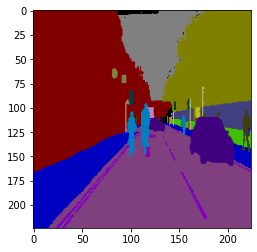

In [11]:
for i  in val_labels:
#     print(onehot2img(i[1]))
    plt.imshow(onehot2img(i[1]))
    plt.show()
    break

# Define backbone model

In [12]:
def Conv_Block(filter_size , inputs ,Conv_skip=True):
    x_skip = inputs
    x = Conv2D(filter_size , (3,3) , padding='same')(inputs)
    x = Activation('relu')(x)
    x = Conv2D(filter_size , (3,3) , padding='same')(x)
#     x = Dropout(0.1)(x)
    if Conv_skip:
        x_skip = Conv2D(filter_size , (3,3) , padding='same')(x_skip)
    x = Add()([x_skip + x])
    x = Activation('relu')(x)
    return inputs
    

In [13]:
inputs = Input((224,224,3))

c1 = Conv2D(16 , (3,3) ,strides=1, padding='same')(inputs)
c1 = Activation('relu')(c1)
# c1 = MaxPooling2D((3,3) , strides=2)(c1)

c2 = Conv_Block(16 , c1 , Conv_skip=False)
c2 = Conv2D(32 , (3,3) ,strides=1, padding='same')(c2)
c2 = Activation('relu')(c2)
c2 = MaxPooling2D((2,2))(c2)
c2 = Dropout(0.1) (c2)

c3 = Conv_Block(32 , c2 , Conv_skip=False)
c3 = Conv2D(64 , (3,3) ,strides=2, padding='same')(c3)
c3 = Activation('relu')(c3)
# c3 = Dropout(0.3) (c3)

c4 = Conv_Block(64 , c3 )
c4 = Conv2D(128 , (3,3) ,strides=2, padding='same')(c4)
c4 = Conv2D(128 , (1,1) ,strides=1, padding='same')(c4)
c4 = Activation('relu')(c4)
c4 = Dropout(0.2) (c4)

c5 = Conv_Block(128 , c4 , Conv_skip=False)
c5 = Conv2D(256 , (3,3) ,strides=1, padding='same')(c5)
c5 = Activation('relu')(c5)
# c5 = Dropout(0.4) (c5)
# 
c6 = Conv_Block(256 , c5 )
c6 = Conv2D(512 , (3,3) ,strides=2, padding='same')(c6)
c6 = Conv2D(512 , (3,3) ,strides=1, padding='same')(c6)
c6 = Activation('relu')(c6)
c6 = Dropout(0.2) (c6)


u1 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c6)
u1 = concatenate([u1, c5])
c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u1)
# c7 = Dropout(0.5) (c7)
c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u2 = Conv2DTranspose(128, (2, 2), strides=(1, 1), padding='same') (c7)
u2 = concatenate([u2, c4])
c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u2)
c8 = Dropout(0.2) (c8)
c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c8)
u3 = concatenate([u3, c3])
c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u3)
# c9 = Dropout(0.2) (c9)
c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

u4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c9)
u4 = concatenate([u4, c2], axis=3)
c10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u4)
# c10 = Dropout(0.3) (c10)
c10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c10)

u4 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c10)
u4 = concatenate([u4, c1], axis=3)
c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u4)
# c11 = Dropout(0.1) (c11)
c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c11)

outputs = Conv2D(32, (1, 1), activation='linear') (c11)

model = Model(inputs=inputs, outputs=outputs)

# Define callbacks function

In [14]:
def scheduler(epoch):
    if epoch < 100:
        return 0.001
    elif epoch < 200:
        return 0.0001
    elif epoch < 150:
        return 0.00001
    else:
        return 0.000001

learning_rate_scheduler = LearningRateScheduler(scheduler, verbose=1)

In [15]:
logdir = 'Resnet_tensorboard/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(logdir)

In [16]:
# os.makedirs("training_3", exist_ok=True)
# python3 -m tensorboard.main --logdir=./segmentation/Unet_tensorboard 
# ckpt_callback = ModelCheckpoint(filepath='Resnet_checkpoint/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss')

# Compile model

In [17]:
model.compile(optimizer='adam', loss=tf.losses.mean_squared_error, metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 224, 224, 16  0           ['conv2d[0][0]']                 
                                )                                                             

 concatenate_3 (Concatenate)    (None, 112, 112, 64  0           ['conv2d_transpose_3[0][0]',     
                                )                                 'dropout[0][0]']                
                                                                                                  
 conv2d_26 (Conv2D)             (None, 112, 112, 32  18464       ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_27 (Conv2D)             (None, 112, 112, 32  9248        ['conv2d_26[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_transpose_4 (Conv2DTran  (None, 224, 224, 16  2064       ['conv2d_27[0][0]']              
 spose)   

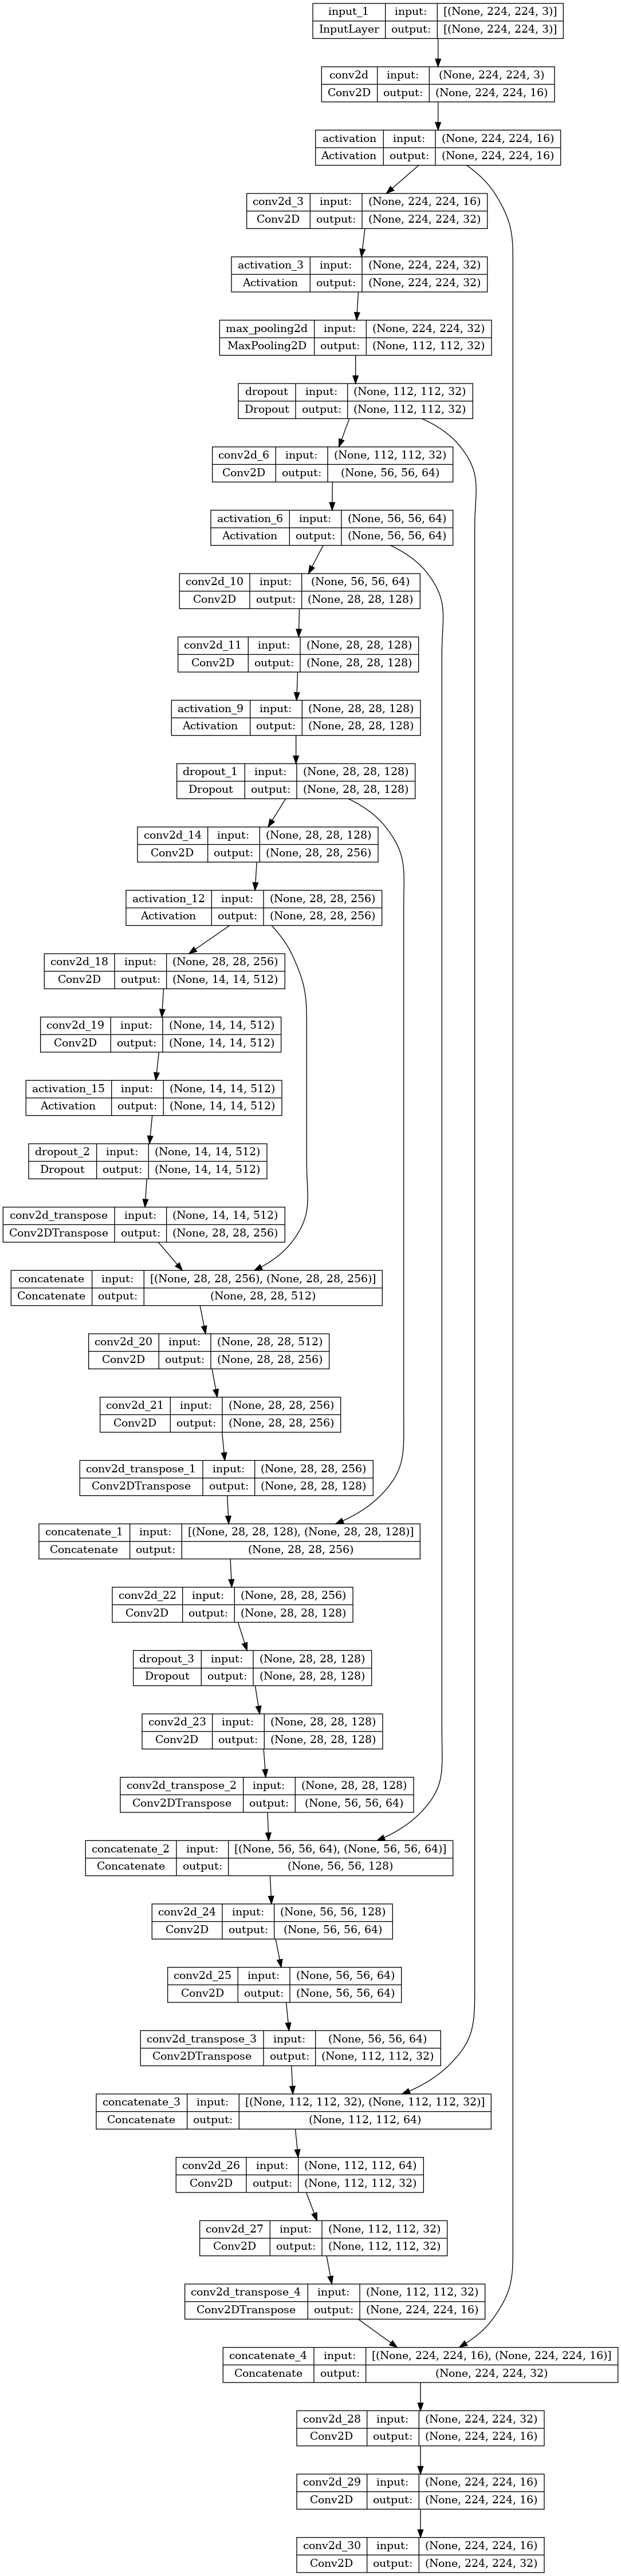

In [18]:
img_file = './Resnetmodel_arch.png'
tf.keras.utils.plot_model(model,to_file=img_file,show_shapes=True, show_layer_names=True)

# Fit model &  Save model

In [19]:
history = model.fit(train_dataset, validation_data=test_dataset,
                    callbacks=[tensorboard_callback],
                    epochs=100)

model.save('Resnet_segmentation_model.hdf5')

Epoch 1/100
123/123 [==============================] - 17s 86ms/step - loss: 0.0276 - accuracy: 0.3632 - val_loss: 0.0239 - val_accuracy: 0.4806
Epoch 2/100
123/123 [==============================] - 10s 66ms/step - loss: 0.0206 - accuracy: 0.5596 - val_loss: 0.0235 - val_accuracy: 0.4531
Epoch 3/100
123/123 [==============================] - 10s 66ms/step - loss: 0.0184 - accuracy: 0.5905 - val_loss: 0.0188 - val_accuracy: 0.5701
Epoch 4/100
123/123 [==============================] - 10s 65ms/step - loss: 0.0163 - accuracy: 0.6253 - val_loss: 0.0180 - val_accuracy: 0.5824
Epoch 5/100
123/123 [==============================] - 10s 66ms/step - loss: 0.0157 - accuracy: 0.6421 - val_loss: 0.0176 - val_accuracy: 0.5834
Epoch 6/100
123/123 [==============================] - 10s 66ms/step - loss: 0.0150 - accuracy: 0.6549 - val_loss: 0.0171 - val_accuracy: 0.6005
Epoch 7/100
123/123 [==============================] - 10s 65ms/step - loss: 0.0145 - accuracy: 0.6650 - val_loss: 0.0167 - val_ac

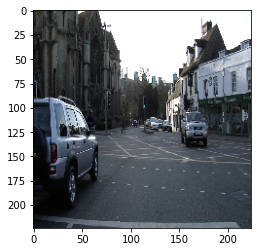

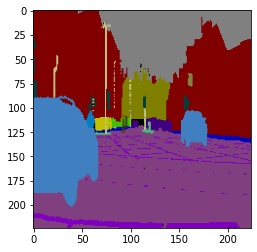

1/1 [==============================] - 0s 174ms/step


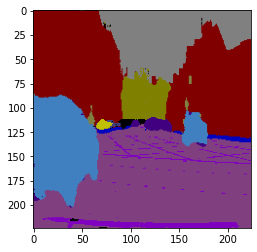

In [20]:
for i ,j in train_dataset:
    plt.imshow(i[0])
    plt.show()
    plt.imshow(onehot2img(j[0]))
    plt.show()
    pred = model.predict(i)
    plt.imshow(onehot2img(pred[0]))
    plt.show()
    break